# Term Deposit Marketing
### Background:

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

### Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

### Goal(s):

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

## Data Wrangling

First, let's import the necessary libraries and load our data.

In [1]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
%matplotlib inline

In [2]:
data=pd.read_csv('../Data/term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
#Now let's check the data for missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


It appears, that we don't have any missing values in any of our 14 columns. Now let's take a look at the values and the distribution of our categorical features.

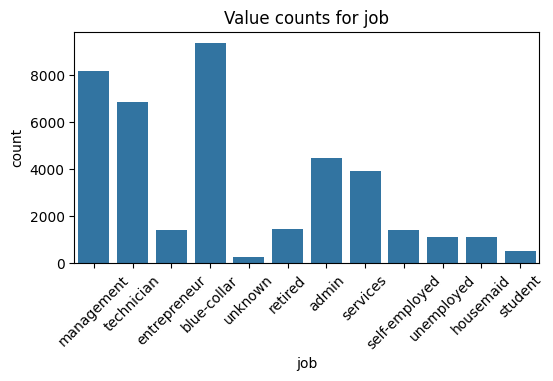

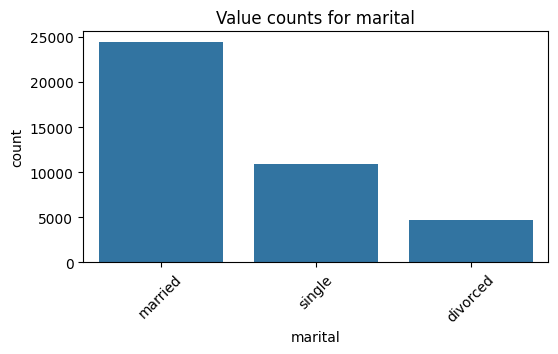

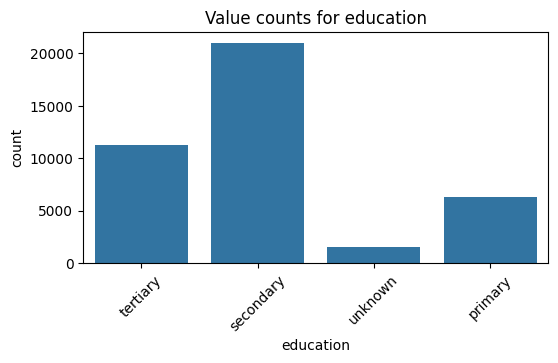

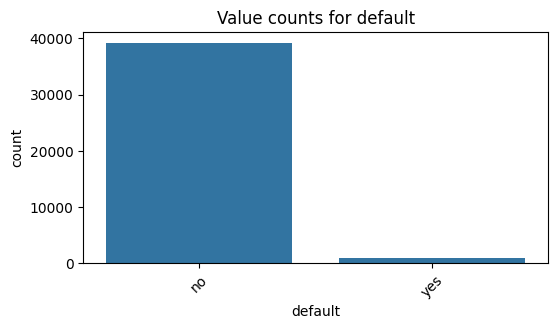

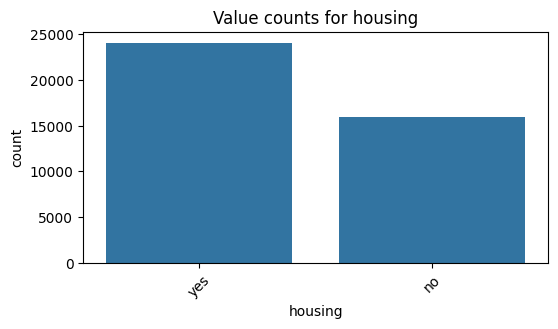

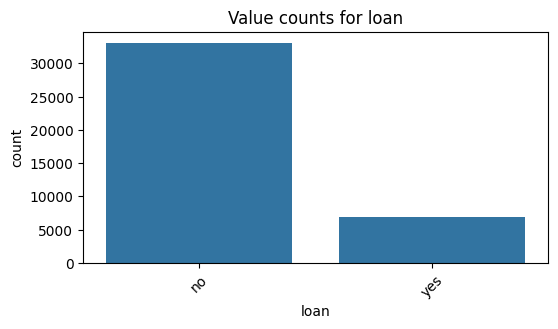

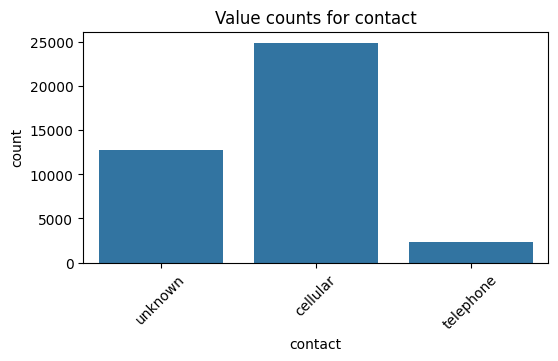

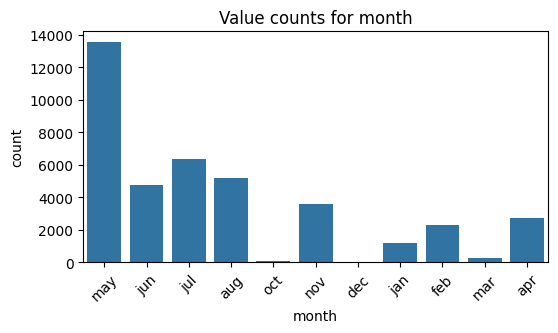

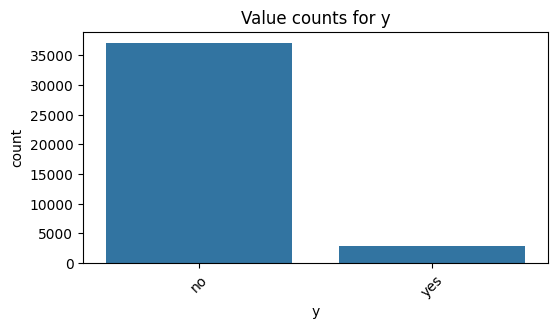

In [4]:
cat_columns=data.select_dtypes(include=['object']).columns
for col in cat_columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data, x=col)
    plt.title(f"Value counts for {col}")
    plt.xticks(rotation=45)
    plt.show()

Although, we don't have missing values in any of our categorical columns, we do have 'unknown' values in 3 columns ('job', 'education' and 'contact'). For job and education, only a small fraction of the values are unknown, whereas for 'contact', around 30% of the values are unknown and another ~60% of examples have a 'cellular' value. So, we can impute our 'unknown' values in the column with the most frequent 'cellular' value.  

In [5]:
data['contact'] = data['contact'].replace('unknown', 'cellular')

In [6]:
#Let's have a look at the distribution of jobs of our customers who didn't mention their education
data.loc[data['education']=='unknown', 'job'].value_counts()

job
blue-collar      439
technician       214
management       189
admin            148
services         135
unknown          104
entrepreneur      74
student           74
retired           59
housemaid         40
self-employed     31
unemployed        24
Name: count, dtype: int64

We have customers with missing education from all the job categories in our data. We can try to impute the missing education by looking at the distribution of the values for each job category, since education and job category are correlated with each other in most cases.

In [7]:
#let's look at the distribution of education per job
pd.crosstab(data['job'], data['education'], normalize='index').round(2)

education,primary,secondary,tertiary,unknown
job,,,,
admin,0.05,0.83,0.09,0.03
blue-collar,0.39,0.55,0.01,0.05
entrepreneur,0.13,0.36,0.46,0.05
housemaid,0.51,0.32,0.14,0.04
management,0.03,0.13,0.82,0.02
retired,0.34,0.46,0.16,0.04
self-employed,0.09,0.39,0.50,0.02
services,0.09,0.84,0.04,0.03
student,0.03,0.54,0.29,0.14


Based on these results, we’ll create a mapping for the missing education values by selecting the most frequently observed education level for each category. Note that in some cases, two levels occur with similar proportions.

In [8]:
job_to_education = {
    'blue-collar': 'secondary',
    'technician': 'secondary',
    'management': 'tertiary',
    'admin': 'secondary',
    'services': 'secondary',
    'unknown': 'unknown', 
    'entrepreneur': 'tertiary',
    'student': 'secondary',
    'retired': 'secondary',
    'housemaid': 'primary',
    'self-employed': 'tertiary',
    'unemployed': 'secondary'
}

data.loc[data['education']=='unknown', 'education'] = data.loc[data['education']=='unknown', 'job'].map(job_to_education)

In [9]:
#Let's take a look at the number of customers with unknown education and job
print(f"Number of customers with unknown education {data[data['education']=='unknown'].shape[0]}")
print(f"Number of customers with unknown jobs {data[data['job']=='unknown'].shape[0]}")

Number of customers with unknown education 104
Number of customers with unknown jobs 235


In [10]:
#Dropping these rows will be the best solution at this point.
data=data[(data['education']!='unknown') & (data['job']!='unknown')]

Next, we’ll modify the 'day' and 'month' columns, which represent the last contact date. Instead of keeping them separately, we’ll create a new column that shows the number of days since the last contact. For reference, we’ll use the latest date in the dataset as the comparison point.

In [11]:
data.loc[data['month']=='dec', 'day'].sort_values(ascending=False).head()

27728    27
27727    22
27726    13
27725    12
27723    11
Name: day, dtype: int64

Since the latest date in our dataset is December 27, we can simplify by using December 31 (the last day of the year) as our reference point. We'll then create a 'recency' column by calculating the number of days between each contact date and December 31, based on the number of days since the beginning of the year.

In [12]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

data['month_num']=data['month'].map(month_map)

data['date']=pd.to_datetime(dict(year=2025, month=data['month_num'], day=data['day']))

data['recency']=365-((data['date']-datetime(2025,1,1)).dt.days)

In [13]:
#Now let's drop all the date related columns
data.drop(columns=['month', 'month_num', 'date', 'day'], inplace=True)

## Exploratory data analysis

As a first step of EDA, let's look at the distribution of our numerical features.

In [14]:
data.describe()

,age,balance,duration,campaign,recency
count,39765.000000,39765.000000,39765.000000,39765.000000,39765.000000
mean,40.512058,1271.895260,254.983226,2.877933,198.764089
std,9.634315,2903.736077,259.531764,3.232940,71.717299
min,19.000000,-8019.000000,0.000000,1.000000,5.000000
25%,33.000000,54.000000,100.000000,1.000000,156.000000
50%,39.000000,406.000000,175.000000,2.000000,216.000000
75%,48.000000,1315.000000,313.000000,3.000000,237.000000
max,95.000000,102127.000000,4918.000000,63.000000,338.000000


The numerical columns generally have reasonable distributions, though there are outliers in all of them . To minimize the impact of these outliers on our model while retaining all data, we will cap extreme values using the z-score method.

In [15]:
num_cols = ['age', 'balance', 'duration', 'campaign', 'recency']
z_thresh = 3

for col in num_cols:
    mean = data[col].mean()
    std = data[col].std()
    upper = mean + z_thresh * std
    lower = mean - z_thresh * std
    # First cap values above the upper threshold
    data[col] = np.where(data[col] > upper, upper, data[col])
    # Then cap values below the lower threshold
    data[col] = np.where(data[col] < lower, lower, data[col])

Next let's replace our binary column values from 'yes' and 'no' to 1 and 0 for our future models.

In [16]:
binary_map = { 'yes':1, 'no':0}
binary_cols= ['default', 'housing', 'loan', 'y']
data[binary_cols]=data[binary_cols].apply(lambda col : col.map(binary_map))

Now let's look at the correlation between our numeric features, using a heatmap.

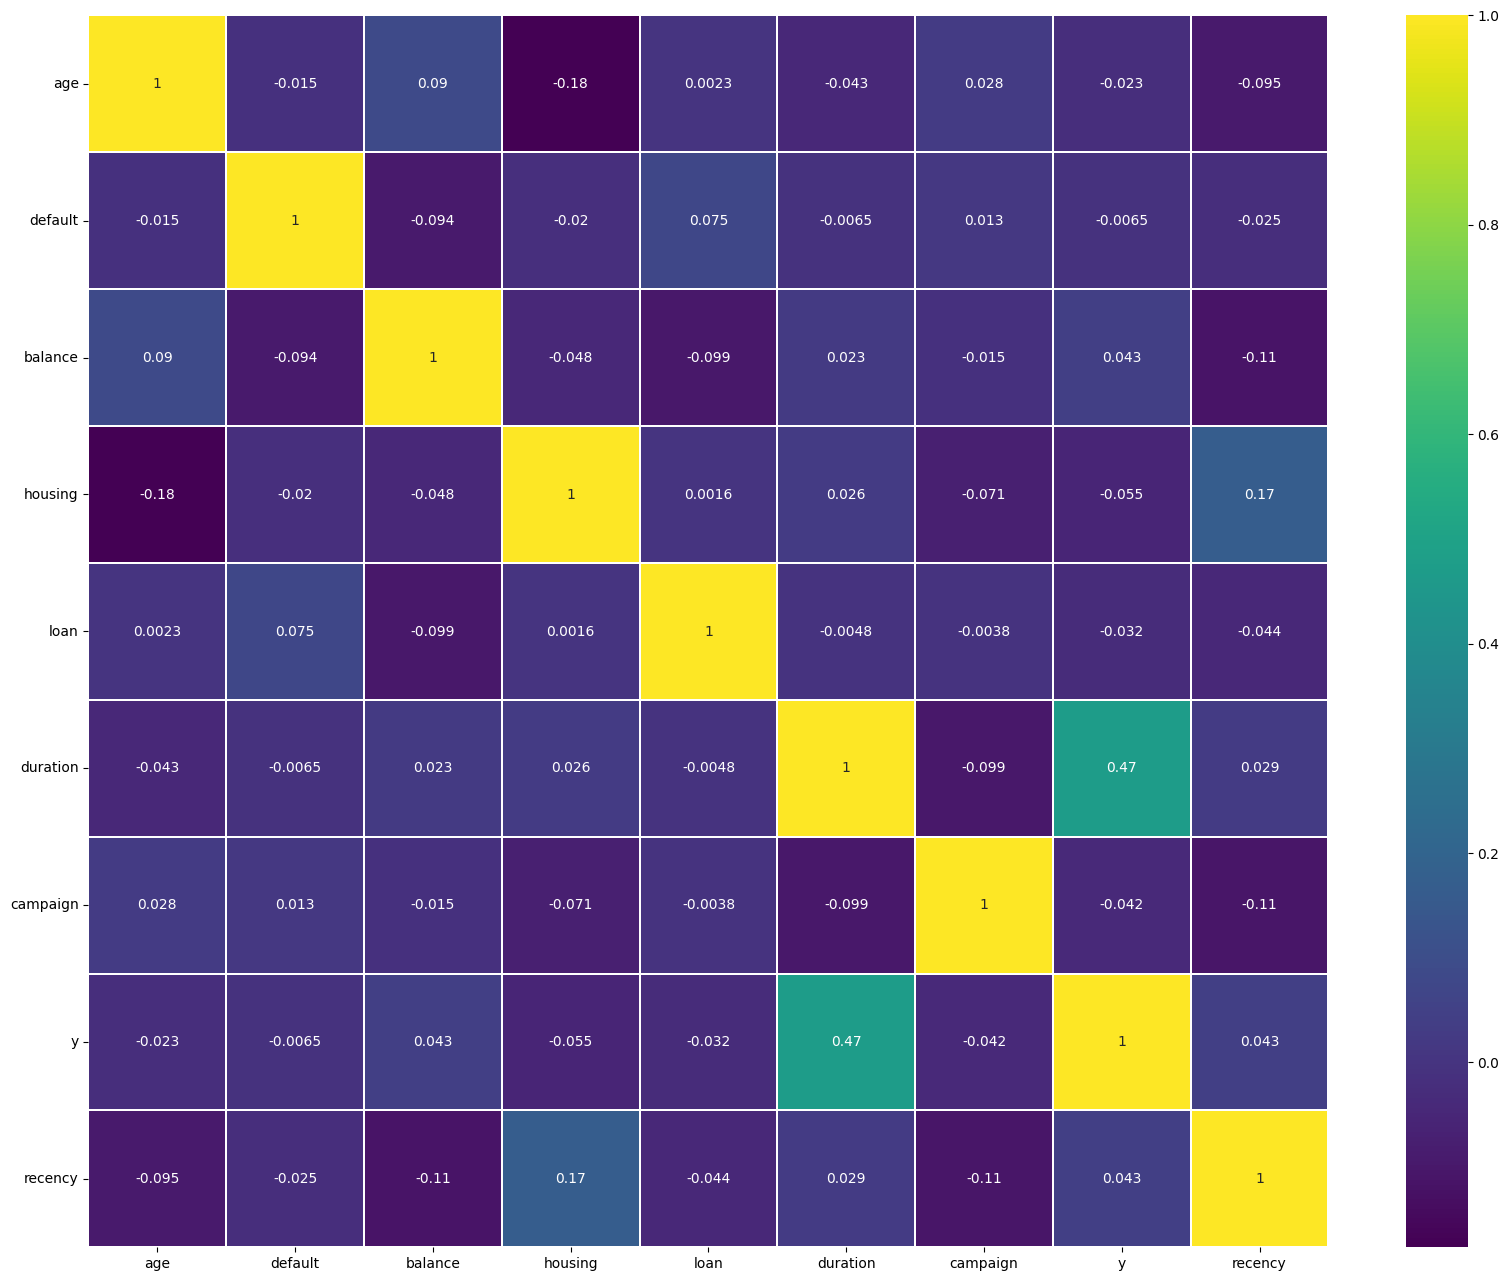

In [17]:
numeric_data = data.select_dtypes(include='number')
plt.figure(figsize=(20,16))
sns.heatmap(numeric_data.corr(), linewidth=.1, annot=True, cmap='viridis')
plt.yticks(rotation=0)
plt.show()

The only noteworthy correlation is between the duration of the last call and a positive outcome (i.e., subscription to a term deposit). This relationship makes sense, as successful subscriptions likely involve longer conversations—possibly due to the need for additional information or follow-up questions from customers who are interested in the service.

And lastly, we need to create dummy variables for our categorical columns and scale the features before proceeding to the modeling section of the project.

In [18]:
#let's create dummy variables for our categorical columns

numeric_data=data.select_dtypes(include='number')

cat_cols=['job', 'marital', 'education']
dummies_data=pd.get_dummies(data[cat_cols]).astype(int)

final_data=pd.concat([numeric_data, dummies_data], axis=1)

final_data.head()

,age,default,balance,housing,loan,duration,campaign,y,recency,job_admin,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58.0,0,2143.0,1,0,261.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,0,1
1,44.0,0,29.0,1,0,151.0,1.0,0,241.0,0,...,0,0,1,0,0,0,1,0,1,0
2,33.0,0,2.0,1,1,76.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,1,0
3,47.0,0,1506.0,1,0,92.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,1,0
5,35.0,0,231.0,1,0,139.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,0,1


In [19]:
#Let's save the modified data before proceeding to the modeling part of the project
final_data.to_csv('../Data/processed_data.csv', index=False)